# Compare vocabulary identity of various substitution matrices

In [1]:
import random
random.seed(0)

def clone_random_vcb(vcb):
    clone = {}
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    def rand_token(t_len):
        generated = ""
        for i in range(t_len):
            generated += random.choice(amino_acids)
        return generated
    for k, v in vcb.items():
        if len(k) == 1:
            clone[k] = v
        else:
            generated = rand_token(len(k))
            while True:
                if generated in clone:
                    generated = rand_token(len(k))
                    continue
                else:
                    clone[generated] = {}
                    break
    return clone
            



In [ ]:
import os
import json

vocab_dict = {}
vocab_dict["BPE"] = {}
vocab_dict["RANDOM"] = {}
vocab_dict["RANDOM"]["BPE"] = {}
for matrix in ["BLOSUM62", "BLOSUM45", "PAM70", "PAM250"]:
    # Requires models trained with multiprocess_train.py
    basepath = f"/cta/share/users/mutbpe/tokenizers/{matrix.lower()}/"
    vocab_dict["RANDOM"][matrix] = {}
    files = os.listdir(basepath)
    vocab_dict[matrix] = {}
    for f in files:
        if "_mutbpe_" in f and "hf_" not in f and "51200." in f and "uniref50_" in f:
            with open(basepath+f) as fl:
                vcb = json.load(fl)
                vocab_dict[matrix][f] = vcb
                vocab_dict["RANDOM"][matrix][f] = clone_random_vcb(vcb) 
            
        if matrix == "BLOSUM62" and "_bpe_" in f and "hf_" not in f and "51200." in f and "uniref50_" in f:
            with open(basepath+f) as fl:
                vcb = json.load(fl)
                vocab_dict["BPE"][f] = vcb
                for i in range(10):
                    vocab_dict["RANDOM"]["BPE"][f"{f}{i}"] = clone_random_vcb(vcb) 



In [3]:
def compare_classes(items, items2):
    scores = []
    # Compute pairwise intersection scores + types
    for i, (fname1, vocab1) in enumerate(items):
        set1 = set(vocab1)
        for j, (fname2, vocab2) in enumerate(items2):
            if(fname1 == fname2) or ("_bpe_" in fname1) or ("_bpe_" in fname2):
                set2 = set(vocab2)
                score = len(set1 & set2) / len(set1)
                scores.append(score)
    return scores


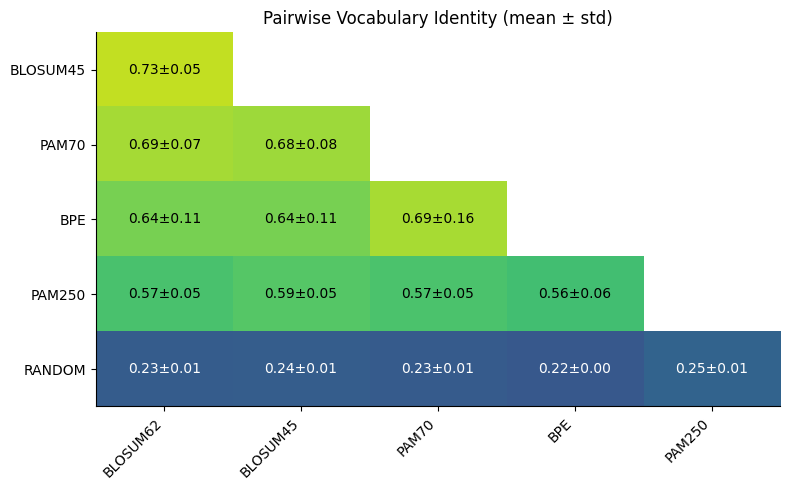

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean, pstdev  # pstdev = population std, use stdev if you want sample std
from mpl_toolkits.axes_grid1 import make_axes_locatable # Added for colorbar fix

# Collect substitution matrices
matrices = ["BLOSUM62", "BLOSUM45", "PAM70", "BPE","PAM250", "RANDOM"]


# Preprocess items (Your original code)
items_dict = {}
for m in matrices:
    if m != "RANDOM":
        items = list(vocab_dict[m].items())
        items.sort()
        items_dict[m] = items
    else:
        items_dict[m] = {}
        for k, v in vocab_dict[m].items():
            items = list(v.items())
            items.sort()
            items_dict[m][k] = items

# Build pairwise comparison results (Your original code)
n = len(matrices)
mean_matrix = np.zeros((n, n))
std_matrix = np.zeros((n, n))
text_matrix = [["" for _ in range(n)] for _ in range(n)]

for i in range(n):
    for j in range(n):
        # We only need to compute for the lower triangle (i > j)
        if i > j:
            if (matrices[i] != "RANDOM" and matrices[j] != "RANDOM"):
                scores = compare_classes(items_dict[matrices[i]], items_dict[matrices[j]])
            elif (matrices[i] == "RANDOM" and matrices[j] != "RANDOM"):
                # This case might need review: RANDOM[j] vs j
                scores = compare_classes(items_dict["RANDOM"][matrices[j]], items_dict[matrices[j]])
            elif (matrices[i] != "RANDOM" and matrices[j] == "RANDOM"):
                # This case might need review: i vs RANDOM[i]
                scores = compare_classes(items_dict[matrices[i]], items_dict["RANDOM"][matrices[i]])
            else:
                # RANDOM vs RANDOM
                scores = compare_classes(items_dict["RANDOM"]["BPE"], items_dict["RANDOM"]["BPE"])

            mu = mean(scores)
            sigma = pstdev(scores)
            mean_matrix[i, j] = mu
            std_matrix[i, j] = sigma
            text_matrix[i][j] = f"{mu:.2f}±{sigma:.2f}"
        elif i == j:
            # You could set diagonal to a specific value, e.g., 1.0 if it's self-comparison
            mean_matrix[i, j] = 1.0 # Or 0.0, or np.nan
            text_matrix[i][j] = "1.00" # Or ""
        else:
            # Set upper triangle to nan from the start
            mean_matrix[i, j] = np.nan


# 1. Create a masked matrix for plotting
# We'll set the upper triangle (k=0 includes diagonal) to np.nan
plot_matrix = mean_matrix.copy()
# Note: The loop above already sets upper to nan, but this is a good safeguard
# k=0 includes the diagonal. Use k=1 to keep the diagonal.
# Let's set diagonal to nan as well for plotting
plot_matrix[np.triu_indices(n, k=0)] = np.nan

# 2. Get the colormap and set 'bad' values (nans) to be white
my_cmap = plt.get_cmap("viridis").copy()
my_cmap.set_bad(color='white')


# --- MODIFICATION START ---

# 3. Slice matrices to remove the first row and last column
# This creates the (n-1) x (n-1) view for the final plot
plot_matrix = plot_matrix[1:, :-1]
# We must slice the text_matrix and labels to match
text_matrix = [row[:-1] for row in text_matrix[1:]]
matrices_x = matrices[:-1]
matrices_y = matrices[1:]
n_plot = n - 1 # New dimension for plotting

# --- MODIFICATION END ---


# Plot heatmap
# You can adjust the width and height by changing figsize
fig, ax = plt.subplots(figsize=(8, 5))
# Use the new (n-1)x(n-1) plot_matrix
im = ax.imshow(plot_matrix, cmap=my_cmap, vmin=0, vmax=0.80)

# --- MODIFICATION START ---

# Set aspect ratio
# 'equal' ensures heatmap cells are square. This is typical for matrices.
# You can change to 'auto' to stretch the heatmap to fill the figsize.
ax.set_aspect('auto')

# --- MODIFICATION END ---


# Add text annotations
# --- MODIFICATION START ---
# 3. Modify the loop to iterate over the new (n-1)x(n-1) matrix
for i in range(n_plot):
    for j in range(n_plot):
        # The condition is now i >= j for the sliced matrix
        if i >= j:
            data_val = plot_matrix[i, j]
            ax.text(j, i, text_matrix[i][j],
                    ha="center", va="center", color="white" if data_val < 0.5 else "black",
                    fontsize=10)
# --- MODIFICATION END ---


# --- MODIFICATION START ---

# Set ticks (Modified to use new n_plot and label lists)
ax.set_xticks(range(n_plot))
ax.set_xticklabels(matrices_x, rotation=45, ha="right")

ax.set_yticks(range(n_plot))
ax.set_yticklabels(matrices_y)

# Remove the top and right plot borders (spines)
# This is still good for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Optional: Remove tick marks on top and right
ax.tick_params(top=False, right=False)

# --- MODIFICATION END ---


# Colorbar
# --- MODIFICATION START ---
# Use make_axes_locatable to create a colorbar axis
# that matches the height of the main axes (ax)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
# cbar = fig.colorbar(im, cax=cax)
# # --- MODIFICATION END ---
# cbar.set_label("Mean Identity")

ax.set_title("Pairwise Vocabulary Identity (mean ± std)")
plt.tight_layout()
# plt.savefig("vocab_identity.eps")
plt.show()

